# Build data with raptor

In [1]:
import sys
sys.path.append("../..")
from datasets import load_dataset
from src.service.provider import ProviderService
provider = ProviderService()
provider.config.enable_tracing("PARA_BOT_DEMO")

In [2]:
DATA_REPO = "BroDeadlines/TEST.UEH.ueh_copora_data"
SPLIT = "train"
SUBSET = 'default'
# test_dataset = load_dataset(DATA_REPO, split= SPLIT)
test_dataset = load_dataset(DATA_REPO, SUBSET)
test_dataset = test_dataset['train']

test_dataset

Dataset({
    features: ['url', 'content', 'doc_id', 'metadata', 'split', 'shards', 'propositions', 'proposition_list', '__index_level_0__'],
    num_rows: 196
})

In [3]:
rows = test_dataset.filter(lambda e: len(e['metadata']) > 0)
rows

Dataset({
    features: ['url', 'content', 'doc_id', 'metadata', 'split', 'shards', 'propositions', 'proposition_list', '__index_level_0__'],
    num_rows: 54
})

## Update the splits

In [4]:
# dataset = test_dataset.remove_columns(['split', 'splits', 'shards'])
dataset = test_dataset
dataset

Dataset({
    features: ['url', 'content', 'doc_id', 'metadata', 'split', 'shards', 'propositions', 'proposition_list', '__index_level_0__'],
    num_rows: 196
})

In [9]:
from src.utils.text_utils import create_splitter, try_split_texts
from src.chain.proposition import create_proposition_chain

contents = dataset['content']
splitter = create_splitter(chunk_size=450, overlap=50, separators=["\n\n\n","\n\n", "\n", '.'])
db, dist,lens = try_split_texts(texts=contents, splitter=splitter)

From 196 texts -> 391
Distribution: Counter({1: 123, 3: 22, 2: 21, 5: 10, 4: 8, 6: 5, 8: 3, 7: 2, 0: 1, 10: 1})
== About the splits ==
The mean of the splits is: 1.9948979591836735
The median of the splits is: 1.0
The max of the split is: 10
The min of the split is: 0
== About the splits length ==
The max of the split length is: 446
The min of the split length is: 8
The mean of the split length is: 273.6547314578005
The median of the split length is: 324.0


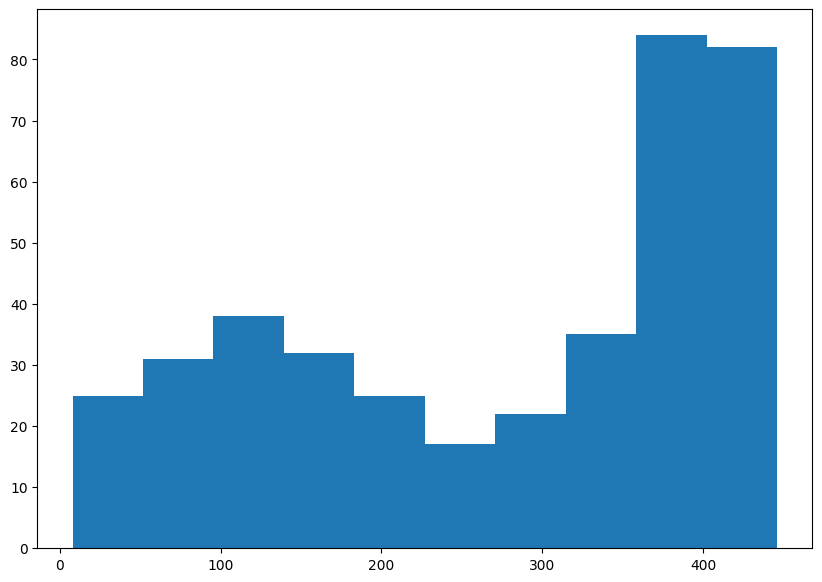

In [10]:
from matplotlib import pyplot as plt 
fig = plt.figure(figsize =(10, 7))
plt.hist(lens)
plt.show()

In [11]:
max_idx = lens.argmax()
lens[max_idx]
txt = db[max_idx].page_content
print(txt)

<Họ tên>, <MSSV>, <nộp học phí học kỳ đầu năm 2024>
Lưu ý: Thông tin mã sinh viên xem trong danh sách trúng tuyển.
Thông tin học phí xem tại link.
Mọi thắc mắc vui lòng gửi đến email tuyensinhvlvh@ueh.edu.vn

CHUẨN BỊ HỒ SƠ NHẬP HỌC
Hồ sơ nhập học gồm có:
– Hồ sơ sinh viên (In trong tài khoản đăng ký);
– Phiếu thông tin sinh viên VB1VLVH (In trong tài khoản đăng ký);
– 02 (hai) Bản sao (photo công chứng) bằng tốt nghiệp THPT/Bổ túc THPT/Trung cấp hoặc Giấy chứng nhận tốt nghiệp tạm thời còn trong thời hạn quy định;
– 01 (một) Bản sao (photo công chứng) Học bạ THPT/Giấy chứng nhận kết quả học THPT/Trung cấp;
– 01 (một) Bản sao (photo công chứng) giấy khai sinh (hoặc CMND/CCCD có đầy đủ ngày tháng năm sinh);
– Thí sinh đã tốt nghiệp Đại học, Cao đẳng/Cao đẳng nghề, Trung cấp/Trung cấp nghề nộp thêm 02 (hai) Bản sao (Photo công chứng) bằng Tốt nghiệp và 01 (một) Bản sao (photo công chứng) kết quả học tập, ghi rõ tên môn học, số tín chỉ, điểm từng môn bậc Đại học/Cao đẳng/Trung cấp. Trường

In [12]:
def create_split(row):
    docs = splitter.split_text(row['content'])
    return {**row, "splits": docs}
    
new_ds = dataset.map(create_split)
new_ds

Map:   0%|          | 0/196 [00:00<?, ? examples/s]

Dataset({
    features: ['url', 'content', 'doc_id', 'metadata', 'split', 'shards', 'propositions', 'proposition_list', '__index_level_0__', 'splits'],
    num_rows: 196
})

In [13]:
a = new_ds[10]['splits']
len(a)

4

## Build RAPTOR tree

In [14]:
from src.rag.raptor import RAPTOR
raptor = RAPTOR(provider, reduce_method="summary")


In [15]:
from src.rag.raptor import RAPTOR
raptor = RAPTOR(provider, reduce_method="summary")

# vec_idx = "vec-raptor-basic_index_tdt_clean"
# text_idx = "text-raptor-basic_index_tdt_clean"

text_idx = "text-raptor-ueh-data-tree-unique"
vec_idx = "vec-raptor-ueh-data-tree-unique"

# text_idx = "text-raptor-medium_index_tdt"
# vec_idx = "vec-raptor-medium_index_tdt"

es = provider.get_elasticsearch_store(vec_idx)
bm = provider.get_elasticsearch_bm25(text_idx)

In [16]:
leaf_ids = []
leaf_texts = []

def collect_data12(row):
    docs = row['splits']
    for d in docs:
        leaf_ids.append(row['doc_id'])
        leaf_texts.append(d)
    return row

a = new_ds.map(collect_data12)
print(len(leaf_texts) ,"-", len(leaf_ids))
a

Map:   0%|          | 0/196 [00:00<?, ? examples/s]

391 - 391


Dataset({
    features: ['url', 'content', 'doc_id', 'metadata', 'split', 'shards', 'propositions', 'proposition_list', '__index_level_0__', 'splits'],
    num_rows: 196
})

In [17]:
print(len(leaf_texts) ,"-", len(leaf_ids))

391 - 391


In [18]:
raptor.test_log("Hello")

raptor.log - ERROR - Hello
NoneType: None
raptor.log - ERROR - Hello
NoneType: None


In [19]:
results = raptor.recursive_embed_cluster_summarize(leaf_texts, leaf_ids, level=1, n_levels=3)

--Generated 68 clusters--


Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.llms._co

--Generated 16 clusters--
--Generated 4 clusters--


### Save pickle

In [20]:
import pickle

with open('ueh_tree_prop_raptor_new.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [3]:
import pickle

# Load data from a file
with open('ueh_tree_prop_raptor_vi.pickle', 'rb') as f:
    results = pickle.load(f)

# results

### Up to Hugging Face

In [21]:
import pandas as pd

def assign_level_id(raptor_tree):
    levels = raptor_tree.keys()
    for level in levels:
        raptor_tree[level][0]['level_id'] = f"tree_{level}"
        raptor_tree[level][1]['level_id'] = f"tree_{level}"
    return

def print_raptor_info(results):
    print(results.keys())
    for i in results.keys():
        print("=======")
        print(len(results[i]))
        print(results[i][0].keys())
        print("->",results[i][0].shape)
        print(results[i][0]['level_id'].unique())
        print(results[i][1].keys())
        print("->",results[i][1].shape)
    return

def flatten_tree(raptor_tree):
    clusters = []
    summarizes = []
    for level in raptor_tree.keys():
        clusters.append(raptor_tree[level][0])
        summarizes.append(raptor_tree[level][1])
    return pd.concat(clusters), pd.concat(summarizes)

In [22]:
assign_level_id(results)
print_raptor_info(results)
clusters, summarizes = flatten_tree(results)

dict_keys([1, 2, 3])
2
Index(['text', 'embd', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (391, 5)
['tree_1']
Index(['summaries', 'level', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (68, 5)
2
Index(['text', 'embd', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (68, 5)
['tree_2']
Index(['summaries', 'level', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (16, 5)
2
Index(['text', 'embd', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (16, 5)
['tree_3']
Index(['summaries', 'level', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (4, 5)


In [26]:
391 + 68 + 16 + 4

479

In [23]:
from datasets import Dataset
cluster_dataset = Dataset.from_pandas(clusters)
print(cluster_dataset)
summerize_dataset = Dataset.from_pandas(summarizes)
summerize_dataset

Dataset({
    features: ['text', 'embd', 'cluster', 'doc_ids', 'level_id', '__index_level_0__'],
    num_rows: 475
})


Dataset({
    features: ['summaries', 'level', 'cluster', 'doc_ids', 'level_id', '__index_level_0__'],
    num_rows: 88
})

In [27]:
CLUSTER_REPO = "BroDeadlines/TEST.PART_CLUSTER.UEH.raptor.edu_data"
SUMMERIZE_REPO = "BroDeadlines/TEST.PART_SUMMERIZE.UEH.raptor.edu_tdt_data"
SUBSET = 'unique'

In [28]:
cluster_dataset.push_to_hub(CLUSTER_REPO, SUBSET)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BroDeadlines/TEST.PART_CLUSTER.UEH.raptor.edu_data/commit/edf1399745f061ee2a11749fc4900884f064b56a', commit_message='Upload dataset', commit_description='', oid='edf1399745f061ee2a11749fc4900884f064b56a', pr_url=None, pr_revision=None, pr_num=None)

In [29]:
summerize_dataset.push_to_hub(SUMMERIZE_REPO, SUBSET)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/495 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BroDeadlines/TEST.PART_SUMMERIZE.UEH.raptor.edu_tdt_data/commit/114d2c189c2b49ab6b068db684150dbb03d5e4fe', commit_message='Upload dataset', commit_description='', oid='114d2c189c2b49ab6b068db684150dbb03d5e4fe', pr_url=None, pr_revision=None, pr_num=None)

In [25]:
cluster_dataset = load_dataset(CLUSTER_REPO, split=SPLIT)
summerize_dataset = load_dataset(SUMMERIZE_REPO, split=SPLIT)

Generating train split:   0%|          | 0/882 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/193 [00:00<?, ? examples/s]

### Up to ES

In [30]:
print_raptor_info(results)

dict_keys([1, 2, 3])
2
Index(['text', 'embd', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (391, 5)
['tree_1']
Index(['summaries', 'level', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (68, 5)
2
Index(['text', 'embd', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (68, 5)
['tree_2']
Index(['summaries', 'level', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (16, 5)
2
Index(['text', 'embd', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (16, 5)
['tree_3']
Index(['summaries', 'level', 'cluster', 'doc_ids', 'level_id'], dtype='object')
-> (4, 5)


In [31]:
391 + 68 + 16 + 4

479

In [32]:
from src.utils.type_utils import create_langchain_doc
# Initialize all_texts with leaf_texts
all_texts = [create_langchain_doc(txt, {"doc_id": id}) for txt, id in zip(leaf_texts, leaf_ids)]
all_texts[0]

Document(metadata={'doc_id': 'e500cddd-2fa4-41ea-8971-300d89059838'}, page_content='HỌC BỔNG TẠI PHÂN HIỆU VĨNH LONG\n\nTrên cơ sở thế mạnh uy tín, chất lượng đào tạo đã được tạo lập trong 47 năm qua, Đại học Kinh tế TP. Hồ Chí Minh (UEH) luôn tiên phong đổi mới để đón đầu và đáp ứng các xu thế phát triển của thị trường, cung cấp nguồn nhân lực chất lượng cao cho nền kinh tế. Đặc biệt, kể từ khi thực hiện chiến lược trở thành Đại học Đa ngành và Bền vững, với định hướng “Đào tạo công dân toàn cầu”, UEH đã có những bước phát triển mạnh mẽ và gặt hái được nhiều thành tích nổi bật trong công tác tuyển sinh, đào tạo.\n\nĐến với UEH, sinh viên Khóa 49 được tự do lựa chọn chương trình học, cách học, và đa dạng cơ hội để trở thành những phiên bản tốt hơn của chính mình. Bên cạnh việc trải nghiệm môi trường giáo dục chuẩn quốc tế, sinh viên còn có cơ hội nhận được nhiều loại học bổng như một lời động viên cho những thí sinh đã có nỗ lực học tập tốt và trúng tuyển vào UEH với kết quả xét tuyển 

In [33]:

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    d_ids = results[level][1]["doc_ids"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend([create_langchain_doc(txt, {"doc_id": id}) for txt, id in zip(summaries, d_ids)])


In [34]:
len(all_texts)

479

In [35]:
print(vec_idx)
print(text_idx)

vec-raptor-ueh-data-tree-unique
text-raptor-ueh-data-tree-unique


In [36]:
b = bm.add_documents(all_texts)

In [37]:
with open("bm_prop_ids_vi.txt", "w") as f:
    f.write("\n".join(b))

In [38]:
a = es.add_documents(all_texts)

In [39]:
with open("es_ids_vi.txt", "w") as f:
    f.write("\n".join(a))

## Update shards

In [40]:
print(len(all_texts))
all_texts[0]

479


Document(metadata={'doc_id': 'e500cddd-2fa4-41ea-8971-300d89059838'}, page_content='HỌC BỔNG TẠI PHÂN HIỆU VĨNH LONG\n\nTrên cơ sở thế mạnh uy tín, chất lượng đào tạo đã được tạo lập trong 47 năm qua, Đại học Kinh tế TP. Hồ Chí Minh (UEH) luôn tiên phong đổi mới để đón đầu và đáp ứng các xu thế phát triển của thị trường, cung cấp nguồn nhân lực chất lượng cao cho nền kinh tế. Đặc biệt, kể từ khi thực hiện chiến lược trở thành Đại học Đa ngành và Bền vững, với định hướng “Đào tạo công dân toàn cầu”, UEH đã có những bước phát triển mạnh mẽ và gặt hái được nhiều thành tích nổi bật trong công tác tuyển sinh, đào tạo.\n\nĐến với UEH, sinh viên Khóa 49 được tự do lựa chọn chương trình học, cách học, và đa dạng cơ hội để trở thành những phiên bản tốt hơn của chính mình. Bên cạnh việc trải nghiệm môi trường giáo dục chuẩn quốc tế, sinh viên còn có cơ hội nhận được nhiều loại học bổng như một lời động viên cho những thí sinh đã có nỗ lực học tập tốt và trúng tuyển vào UEH với kết quả xét tuyển 

In [41]:
def build_shards(all_data):
    shards_map = {}
    shards = {}
    for doc in all_data:
        d_id = doc.metadata['doc_id']
        # update new record
        if d_id not in shards_map:
            shards_map[d_id] = 1
            shards[d_id] = 1
        else:
            shards_map[d_id] += 1
            shards[d_id] += 1
        # update sub-tree
        if ";" not in d_id:
            continue
        keys = shards_map.keys()
        for k in keys:
            if k in d_id:
                shards_map[k] += 1
    return shards, shards_map

shards, hard_shards = build_shards(all_texts)
print(sum(shards.values()))
print(sum(hard_shards.values()))

479
1614


In [42]:
print(cluster_dataset)
summerize_dataset

Dataset({
    features: ['text', 'embd', 'cluster', 'doc_ids', 'level_id', '__index_level_0__'],
    num_rows: 475
})


Dataset({
    features: ['summaries', 'level', 'cluster', 'doc_ids', 'level_id', '__index_level_0__'],
    num_rows: 88
})

In [43]:
def update_shards(row):
    row['easy_shards'] = shards[row['doc_ids']]
    row['hard_shards'] = hard_shards[row['doc_ids']]
    return row
    
cluster_dataset_one = cluster_dataset.map(update_shards)
summerize_dataset_one = summerize_dataset.map(update_shards)

Map:   0%|          | 0/475 [00:00<?, ? examples/s]

Map:   0%|          | 0/88 [00:00<?, ? examples/s]

In [44]:
summerize_dataset_one = summerize_dataset_one.remove_columns(['__index_level_0__'])
cluster_dataset_one = cluster_dataset_one.remove_columns(['__index_level_0__'])
print(cluster_dataset_one)
summerize_dataset_one

Dataset({
    features: ['text', 'embd', 'cluster', 'doc_ids', 'level_id', 'easy_shards', 'hard_shards'],
    num_rows: 475
})


Dataset({
    features: ['summaries', 'level', 'cluster', 'doc_ids', 'level_id', 'easy_shards', 'hard_shards'],
    num_rows: 88
})

In [45]:
print(CLUSTER_REPO)
print(SUMMERIZE_REPO)
SPLIT

BroDeadlines/TEST.PART_CLUSTER.UEH.raptor.edu_data
BroDeadlines/TEST.PART_SUMMERIZE.UEH.raptor.edu_tdt_data


'train'

In [46]:
cluster_dataset_one.push_to_hub(CLUSTER_REPO, SUBSET)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/984 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BroDeadlines/TEST.PART_CLUSTER.UEH.raptor.edu_data/commit/c29fe76ac0ed5f98d386d142ca5cb6086bf678fe', commit_message='Upload dataset', commit_description='', oid='c29fe76ac0ed5f98d386d142ca5cb6086bf678fe', pr_url=None, pr_revision=None, pr_num=None)

In [47]:
summerize_dataset_one.push_to_hub(SUMMERIZE_REPO, SUBSET)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/969 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BroDeadlines/TEST.PART_SUMMERIZE.UEH.raptor.edu_tdt_data/commit/6731d21ad3c893f677deba30dc8229b2d8719279', commit_message='Upload dataset', commit_description='', oid='6731d21ad3c893f677deba30dc8229b2d8719279', pr_url=None, pr_revision=None, pr_num=None)

## Done